In [ ]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

warnings.filterwarnings("ignore")
plt.rcParams.update({
    "figure.dpi": 150,
    "font.size": 10,
})

from nebula.data.dataset import CLASSES, GalaxyDatasetSource, GalaxyDatasetTarget
from nebula.modeling.ota_loss import TopKPairwiseLoss, _pairwise_sq_dist
from nebula.models._resnet import ResNetBackbone, ResNetConfig
from nebula.commons import set_all_seeds

In [2]:
SRC_LABEL_PATH = Path("../data/source/source_galaxy_labels.csv")
SRC_IMG_PATH = Path("../data/source/galaxy_images_rgb")
TGT_LABEL_PATH = Path("../data/target/gz2_galaxy_labels.csv")
TGT_IMG_PATH = Path("../data/target/gz2_images")

# Parameters
SEED = 42
K = 8  # Number of top/bottom examples to show
MAX_SAMPLES = 50  # Max samples to pull from each dataset
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SRC_MEAN = [0.10848670452833176, 0.117486372590065, 0.09117863327264786]
SRC_STD = [0.2009781301021576, 0.21104967594146729, 0.1836480051279068]
TGT_MEAN = [0.04405268281698227, 0.03992829844355583, 0.032875481992959976]
TGT_STD = [0.0869700163602829, 0.0758928582072258, 0.07477222383022308]


set_all_seeds(SEED)

In [3]:
def denormalize_image(img, mean, std):
    img = img.clone()
    if mean is not None and std is not None:
        for t, m, s in zip(img, mean, std):
            t.mul_(s).add_(m)
    img = torch.clamp(img, 0, 1)
    return img


def get_features(loader: DataLoader, model: nn.Module, device: torch.device, max_samples: int):
    features_list = []
    labels_list = []
    images_list = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            _, features = model(imgs)

            features_list.append(features.cpu())
            labels_list.append(labels)
            images_list.extend([img.cpu() for img in imgs])

            if max_samples is not None:
                total = sum(len(f) for f in features_list)
                if total >= max_samples:
                    break

    all_features = torch.cat(features_list, dim=0)
    all_labels = torch.cat(labels_list, dim=0)

    if max_samples is not None and len(all_features) > max_samples:
        all_features = all_features[:max_samples]
        all_labels = all_labels[:max_samples]
        images_list = images_list[:max_samples]

    return all_features, all_labels, images_list

In [4]:
def plot_alignment_grid(
    src_data,
    tgt_data,
    alignment_info,
    indices_to_plot,
    title_prefix,
    topk_loss_value,
):
    k = len(indices_to_plot)
    row_minima = alignment_info['row_minima']
    col_indices = alignment_info['col_indices']
    
    fig, axes = plt.subplots(k, 3, figsize=(14, k * 4))

    for rank, src_idx in enumerate(indices_to_plot):
        src_idx = int(src_idx)
        tgt_idx = int(col_indices[src_idx])
        distance = row_minima[src_idx].item()
        src_class = CLASSES[src_data['labels'][src_idx].item()]
        tgt_class = CLASSES[tgt_data['labels'][tgt_idx].item()]

        ax_src, ax_tgt, ax_latent = axes[rank]

        # --- Source Image ---
        src_img = src_data['images'][src_idx]
        src_img_np = torch.clamp(src_img, 0, 1).permute(1, 2, 0).numpy()
        ax_src.imshow(src_img_np, interpolation='bilinear')
        ax_src.set_title(f'Src #{src_idx}: {src_class}', fontsize=11, fontweight='bold')
        ax_src.axis('off')

        # --- Target Image ---
        tgt_img = tgt_data['images'][tgt_idx]
        tgt_img_np = torch.clamp(tgt_img, 0, 1).permute(1, 2, 0).numpy()
        ax_tgt.imshow(tgt_img_np, interpolation='bilinear')
        ax_tgt.set_title(f'Tgt #{tgt_idx}: {tgt_class}', fontsize=11, fontweight='bold')
        ax_tgt.axis('off')

        # --- Latent Space Visualization ---
        src_xy = src_data['features'][src_idx, :2]
        tgt_xy = tgt_data['features'][tgt_idx, :2]

        ax_latent.scatter(src_xy[0], src_xy[1], c='blue', marker='o', s=100, label='Source')
        ax_latent.scatter(tgt_xy[0], tgt_xy[1], c='red', marker='^', s=100, label='Target')
        ax_latent.plot([src_xy[0], tgt_xy[0]], [src_xy[1], tgt_xy[1]], 'k--', linewidth=1)

        ax_latent.set_title(f'Latent Distance: {distance:.3f}', fontsize=11, fontweight='bold')
        ax_latent.legend()
        ax_latent.grid(False)

    plt.suptitle(
        f'Top-{k} {title_prefix} Source Images\n'
        f'TopKPairwiseLoss: {topk_loss_value:.4f}',
        fontsize=16, fontweight='bold', y=1.02
    )
    plt.tight_layout()
    plt.close()
    return fig

In [5]:
# Load the datasets

transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
    transforms.ToTensor(),
])

src_dataset = GalaxyDatasetSource(
    SRC_LABEL_PATH,
    SRC_IMG_PATH,
    transform=transform,
    include_rotations=False,
)
tgt_dataset = GalaxyDatasetTarget(
    TGT_LABEL_PATH,
    TGT_IMG_PATH,
    transform=transform,
)

src_loader = DataLoader(
    src_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Keep order for consistency
)
tgt_loader = DataLoader(
    tgt_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [6]:
# get the model

model = ResNetBackbone(ResNetConfig())
model.to(DEVICE)
model.eval()

ResNetBackbone(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [7]:
src_features, src_labels, src_images = get_features(
    src_loader, model, DEVICE, MAX_SAMPLES
)
print(f"Source features shape: {src_features.shape}, images: {len(src_images)}")

print("Extracting target features...")
tgt_features, tgt_labels, tgt_images = get_features(
    tgt_loader, model, DEVICE, MAX_SAMPLES
)
print(f"Target features shape: {tgt_features.shape}, images: {len(tgt_images)}")


Source features shape: torch.Size([50, 512]), images: 50
Extracting target features...
Target features shape: torch.Size([50, 512]), images: 50


In [8]:
B_src, B_tgt = src_features.size(0), tgt_features.size(0)

# (B_src, B_tgt)
cost_matrix = _pairwise_sq_dist(src_features, tgt_features)

# Find the closest target for each source
# row_minima: (B_src,) - The min distance for each source sample
# col_indices: (B_src,) - The index of the target sample that gave that min distance
row_minima, col_indices = cost_matrix.min(dim=1)

# Calculate the actual TopKPairwiseLoss
topk_loss_fn = TopKPairwiseLoss(k=K)
topk_loss_value = topk_loss_fn(src_features, tgt_features)

# Get the indices of the WORST aligned source samples (largest min-distances)
vals_worst, indices_worst = torch.topk(row_minima, k=min(K, B_src), largest=True)

# Get the indices of the BEST aligned source samples (smallest min-distances)
vals_best, indices_best = torch.topk(row_minima, k=min(K, B_src), largest=False)

print(f"TopKPairwiseLoss value: {topk_loss_value.item():.4f}")
print(f"Top-{K} largest row-minima (worst-aligned):\n {vals_worst.tolist()}")
print(f"Top-{K} smallest row-minima (best-aligned):\n {vals_best.tolist()}")

TopKPairwiseLoss value: 240.6735
Top-8 largest row-minima (worst-aligned):
 [502.8573303222656, 392.9183654785156, 176.8967742919922, 176.1962432861328, 174.57122802734375, 172.44082641601562, 166.95291137695312, 162.55426025390625]
Top-8 smallest row-minima (best-aligned):
 [31.369504928588867, 40.39215087890625, 42.80177307128906, 48.5432014465332, 58.6480827331543, 59.939334869384766, 60.609378814697266, 62.181156158447266]


In [9]:
# prepare data for plotting

indices_worst_np = indices_worst.detach().cpu().numpy()
indices_best_np = indices_best.detach().cpu().numpy()
col_indices_np = col_indices.detach().cpu().numpy()

src_features_np = src_features.detach().cpu().numpy()
tgt_features_np = tgt_features.detach().cpu().numpy()

# Group data into dictionaries for cleaner function calls
src_data = {
    'images': src_images,
    'labels': src_labels,
    'features': src_features_np,
}
tgt_data = {
    'images': tgt_images,
    'labels': tgt_labels,
    'features': tgt_features_np,
}
alignment_info = {
    'row_minima': row_minima,
    'col_indices': col_indices_np,
}

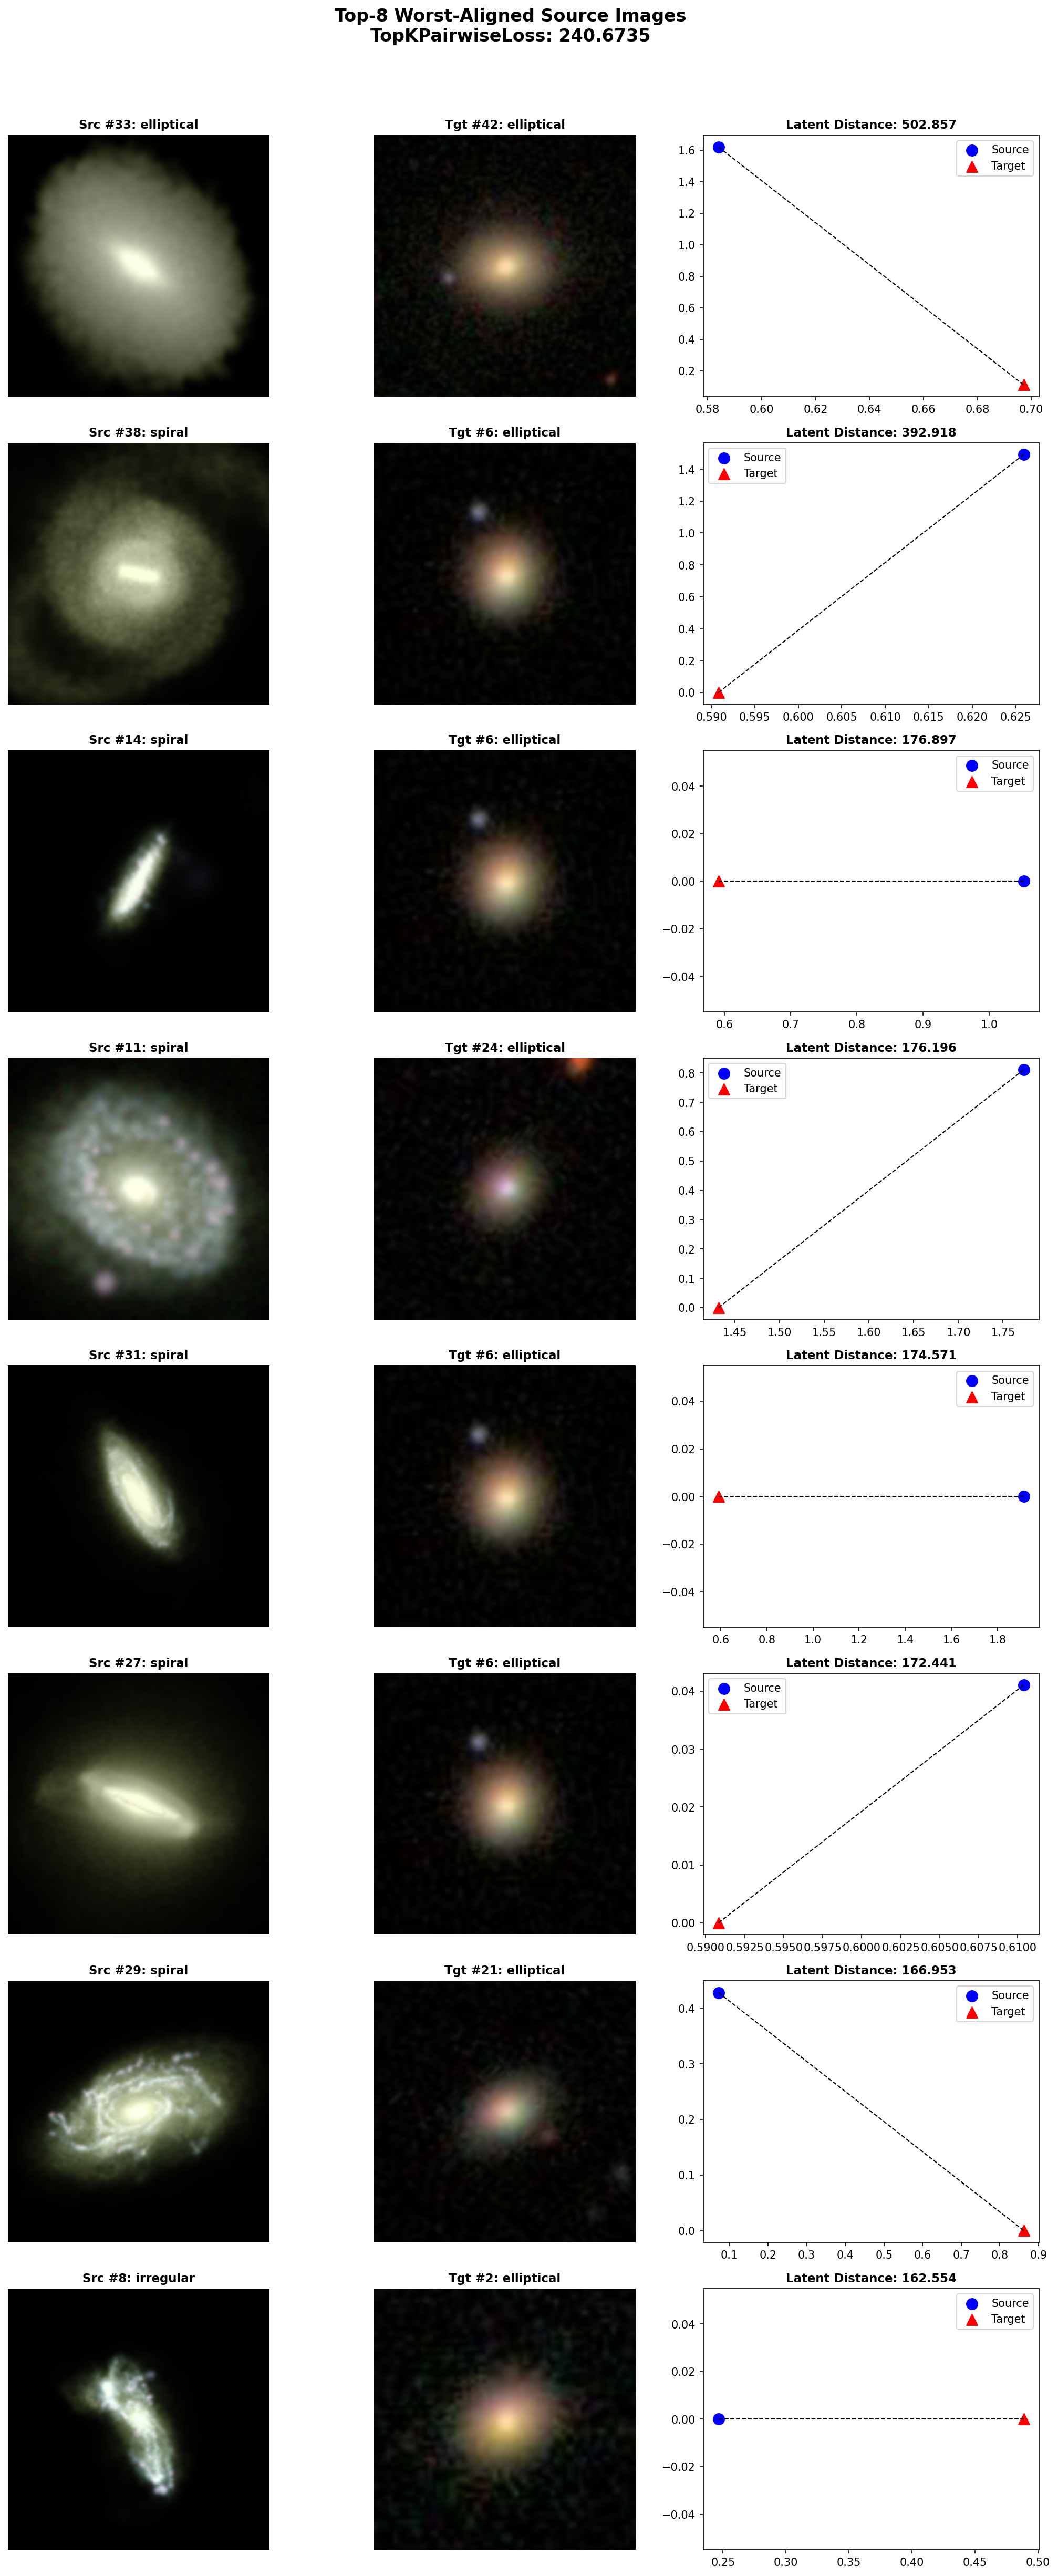

In [10]:
# Plot the worst-aligned examples

plot_alignment_grid(
    src_data=src_data,
    tgt_data=tgt_data,
    alignment_info=alignment_info,
    indices_to_plot=indices_worst_np,
    title_prefix="Worst-Aligned",
    topk_loss_value=topk_loss_value.item(),
)

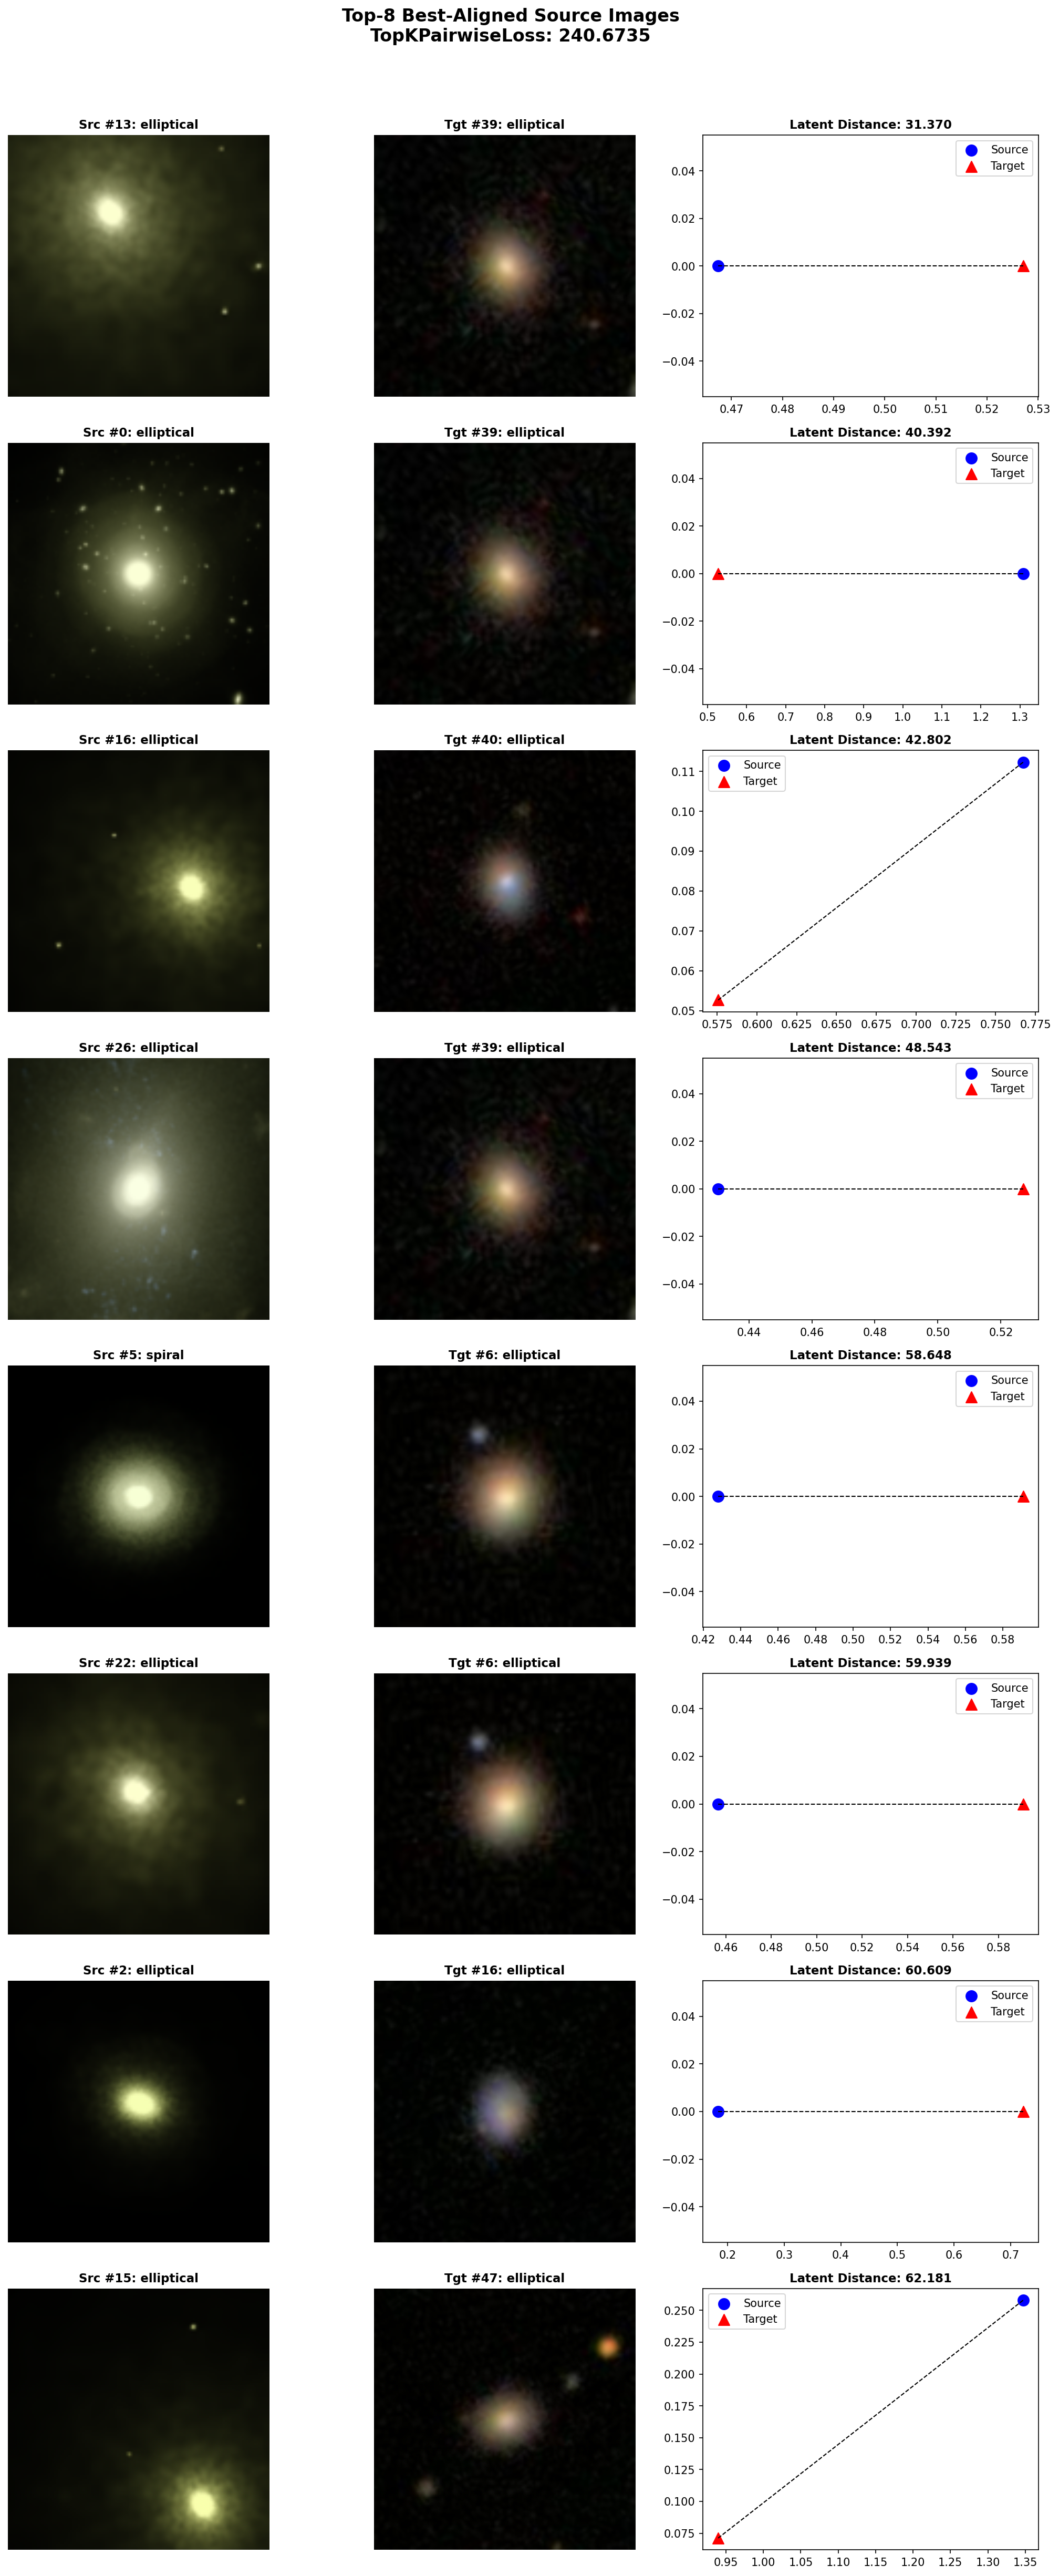

In [11]:
# Plot the best-aligned examples

plot_alignment_grid(
    src_data=src_data,
    tgt_data=tgt_data,
    alignment_info=alignment_info,
    indices_to_plot=indices_best_np,
    title_prefix="Best-Aligned",
    topk_loss_value=topk_loss_value.item(),
)